In [ ]:
from random import sample
offset = 1
select_num = 0
upper = 4
a = list(range(10))
r = sample(range(upper), k=(select_num % upper))
[i + offset for i in range(upper) for _ in range(select_num // upper + (i in r))]
a[:2]


In [ ]:
import math
def weighted_split(nums, ratio, mode = math.ceil):
        if len(ratio) <= 1:
            return nums,
        else:
            out = mode(nums * ratio[0]/sum(ratio))
            return out, *weighted_split(nums - out, ratio = ratio[1:], mode = mode)

weighted_split(100, (0.33,0.42,0.17))

In [ ]:
a = 999
p = (0.3,0.3,0.3)
print([a * i / sum(p) for i in p])

In [ ]:
a = []
a.extend(i for i in range(10))
a

In [ ]:
from datasets.dataset import indexGen
import os
path = "/home/supercgor/gitfile/ARAI/datasets/data/HDA/afm"
a = indexGen(use_len= 5, out_len = 16, rand= True)
for i in os.listdir(path):
    if "HDA_5" in i:
        print(a.get(f"{path}/{i}"))

In [ ]:
import time
from tqdm import tqdm
epoch = 0
pbar = tqdm(total = 100,desc = str(epoch), position = 0)
for i in range(10):
    pbar.update(1)
    epoch += 1
pbar.close()

print("done!")

In [ ]:
import torch
from network.NLayerNN import NLayerDiscriminator
netA = NLayerDiscriminator(in_channels = 1)
netB = NLayerDiscriminator(in_channels = 1)
netA.requires_grad_(False)
netB.requires_grad_(True)
inp = torch.rand((1,1,128,128))
x = netA(inp)
x = netB(inp * x)
netA.requires_grad_(True)
netB.requires_grad_(False)
x = netA(inp)
x = netB(inp * x)
x.backward()
netB.requires_grad_(True)


grads = []
for param in netA.parameters():
    if param.grad is None:
        print("None")
        break
    grads.append(param.grad.view(-1))
else:
    grads = torch.cat(grads)
    print(grads.mean())

grads = []
for param in netB.parameters():
    if param.grad is None:
        print("None")
        break
    grads.append(param.grad.view(-1))
else:
    grads = torch.cat(grads)
    print(grads.mean())

In [ ]:
from utils.logger import Logger
import time
from tqdm import tqdm
a = Logger("/home/supercgor/gitfile/ARAI", "123.log")
top = tqdm(total= 100, desc=f"TOP", position=0, leave=True, unit='it')
mid = tqdm(total= 50, desc=f"MID", position=1, leave=False, unit='it')
bot = tqdm(total= 50, desc=f"BOT", position=2, leave=False, unit='it')
for i in range(100):
    for j in range(50):
        time.sleep(0.2)
        mid.update(1)
    for j in range(50):
        time.sleep(0.1)
        bot.update(1)        
    top.update(1)

In [ ]:
import numpy as np
a = np.random.rand(10000,2)
b = np.random.rand(10, 10000) > 0.5
b @ a / 10000


In [ ]:
from network.unet3d_model import TransUNet3D
from network.basic import basicParallel
from torch import nn
import torch
import numpy as np


In [ ]:
preds = []
preds.append(torch.load("/home/supercgor/gitfile/ARAI/datasets/data/exp/npy/9A_basel/HDA_3_-1_-1_1_1.npy"))
preds.append(torch.load("/home/supercgor/gitfile/ARAI/datasets/data/exp/npy/9A_basel/HDA_3_-1_-1_0_1.npy"))
preds = np.asarray(preds)
preds = torch.from_numpy(preds)
sp = tuple(preds.shape)
sp = (*sp[:-1], sp[-1] // 4 , 4)
preds = preds.reshape(sp)
print(preds.shape)
preds = torch.permute(preds, (0, 4, 1, 2, 3, 5))
a = np.moveaxis(np.indices((32,32,9)), 0, -1)
print(preds.shape)
pos = (preds[...,:3] + a)
pos = pos.reshape((*pos.shape[:2], -1, 3)) 
select = (preds[...,3] > 0).reshape(*pos.shape[:2], -1)
print(pos.shape)
print(select.shape)
pos = pos.mul(select)

In [ ]:
from collections import OrderedDict
class a():
    def __init__(self, b: OrderedDict):
        self.b = b

e = {"O": 1.4, "H": 1.5}
c = OrderedDict(e)
c

In [ ]:
import torch
from torchvision.utils import make_grid
import math
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64).cuda()
imgs_dist1 = torch.ones((20, 4, 32, 32), device="cuda") * 255
imgs_dist1 = imgs_dist1.to(dtype = torch.uint8)
row = math.ceil(math.sqrt(imgs_dist1.shape[1]))
imgs_dist1 = imgs_dist1.view(20,4, 1, 32, 32)
imgs_dist1 = imgs_dist1.expand(-1, -1, 3, -1, -1)

imgs_dist2 = torch.randn((20, 4, 32, 32), device="cuda") * 255
imgs_dist2 = imgs_dist2.to(dtype = torch.uint8)
row = math.ceil(math.sqrt(imgs_dist2.shape[1]))
imgs_dist2 = imgs_dist2.view(20,4, 1, 32, 32)
imgs_dist2 = imgs_dist2.expand(-1, -1, 3, -1, -1)

for i in imgs_dist1:
    img = make_grid(i, nrow = row, padding= 0)
    fid.update(i, real=True)

for i in imgs_dist2:
    img = make_grid(i, nrow = row, padding= 0)
    fid.update(i, real=False)

fid.compute()

for i in imgs_dist1:
    img = make_grid(i, nrow = row, padding= 0)
    fid.update(i, real=True)

for i in imgs_dist2:
    img = make_grid(i, nrow = row, padding= 0)
    fid.update(i, real=False)


fid.compute()

In [ ]:
import torch
import numpy as np
predictions = torch.randn((16, 32, 32, 4, 8))
batch, X, Y, Z, last = predictions.shape
P = predictions[..., range(3,last,4)] > 0
P = torch.permute(P, (0, 4, 3, 1, 2))  # X, Y, Z, C -> C, Z, H, W
P = P.reshape((batch * 2 * Z, 1, X, Y))
P.shape

In [ ]:
from datasets.dataset import read_pic
from torchvision.utils import save_image
imgs = read_pic("/home/supercgor/gitfile/ARAI/datasets/data/exp/afm/HDA_3_-1_-1_0_0", [0,1,2,3])
print(imgs.shape)
imgs = imgs.view(1, 256, 256)
save_image(imgs, "./img.png")


In [ ]:
from utils.metrics import Analyzer, Analyzer2
from utils.loader import poscarLoader
from config import get_config
from collections import OrderedDict
import numpy as np
import torch
a = torch.load("/home/supercgor/gitfile/ARAI/datasets/data/exp/npy/3A_with_more_data/HDA_3_-1_-1_0_1.npy")
b = torch.load("/home/supercgor/gitfile/ARAI/datasets/data/exp/npy/3A_with_more_data/HDA_3_-1_-1_0_1.npy")
a, b = torch.from_numpy(a), torch.from_numpy(b)
B = Analyzer2(sort=True, threshold = 0)
C = Analyzer(get_config())
info = E = C(a,b)
F = B(a,b)
#print(OP)
print(len(E['P_nms'][0][0]), len(set(E['TP_index_nms'][0][0][0].tolist())), len(E['P_nms'][0][1]), len(set(E['TP_index_nms'][0][1][0].tolist())))
print(len(B.TP['O'][0]), len(B.FP['O'][0]), len(B.FN['O'][0]), len(B.TP['H'][0]), len(B.FP['H'][0]), len(B.FN['H'][0]))
poscarLoader.pos2poscar("./test.poscar",OrderedDict(O = B.P['O'][0], H = B.P['H'][0]))
print(f"{len(B.TP['O'][0])}\n",B.TP['O'][0], f"\n{len(B.TP['H'][0])}\n",B.TP["H"][0])

In [ ]:
box = poscarLoader.pos2box({"O": B.P['O'][0], "H": B.P["H"][0]}, (3, 25, 25), (4, 32, 32))
IND = box[...,3].nonzero()
print(IND.shape)
print(box[IND[...,0],IND[...,1],IND[...,2],IND[...,3]])

In [ ]:
from network.stylegan2_pytorch.stylegan2_pytorch import Generator
from network.basic import basicModel
import torch
class g(basicModel, Generator):
    def __init__(self, *args, **kwargs):
        Generator.__init__(self, *args, **kwargs)
        basicModel.__init__(self)

a = Generator(32,32)
b = torch.rand(1,256)
c = torch.randn(1,32,32,1)
a(b,c)

In [ ]:
from kornia.filters import filter3d
import torch
from torch import nn, einsum
import einops    

w1 = torch.ones(3, 10, 3, 3, 3)
w2 = torch.rand(1, 10)
einops.einsum(w1,w2,"O S P Q R, B S -> (B O) S P Q R")
a = einsum("O I P Q R, B S -> B O IS P Q R", w1, w2)
a[0,0]
#einops.rearrange(img, "b c 1 h w -> b c h w").shape
# f = torch.Tensor([1, 2, 1])
# f = einsum("i,j,k->ijk", f,f,f)
# print(f)

In [ ]:
from network.styleGAN_cond_q3d.op import MapStyle3d
from network.basic import structure
import torch

X = torch.randn(4, 32, 16, 128, 128)
Y = torch.randn(4, 32, 16, 64, 64)
Z = torch.randn(4, 64, 16, 32, 32)
R = torch.randn(4, 128, 8, 16, 16)
S = torch.randn(4, 256, 4, 8, 8)

a = MapStyle3d(512)
a(X)
a(Y)
a(Z)
a(R)
a(S)
structure(a)

In [ ]:
import torch
from network.unet3d_model import UNet3D
a = UNet3D()
x = torch.randn(4, 1, 16, 128, 128)
x = x[:,:,0,0,0]
print(x)

In [ ]:
# 在target 處的 confidence + 上 0.1的sigma 再放進去discri
import torch
from network.styleGAN_cond_q3d import StyleGAN3D, Discriminator3D
from network.fea_Unet3d import UNet3D
from network.basic import structure
a = StyleGAN3D(network_capacity = 32).cuda()
b = UNet3D().cuda()
c = Discriminator3D(network_capacity= 16).cuda()
b.requires_grad_(False)
# a.requires_grad_(False)
x = torch.randn((2, 1, 16, 128, 128)).cuda()
x, f = b(x)
noise = torch.randn((2, 16, 128, 128, 1)).cuda()

In [ ]:
import einops
result = a(f, noise)
result = torch.cat([x, result], dim = 1)
print(result.shape)
c(result).mean().backward()

In [ ]:
print(*map(lambda x: x.shape, f))

In [ ]:
from torch.nn import functional as F
a = torch.randn(2,16)
b = torch.randn(512,16)
F.linear(a, b)

In [ ]:
from torch import einsum
k = torch.Tensor([1,2,1])
einsum("i, j, k -> ijk", k,k,k)[None,...].shape

In [ ]:
import torch
a = torch.randn(1, 8, 1, 4, 4)

In [ ]:
from einops import repeat, rearrange, einsum
import torch
POS = torch.FloatTensor(10000,3).uniform_(0,25)
x = torch.randn(1, 8 ,25,25,25)
s = torch.tensor([0.5,0.5,0.5, 1])
y = torch.ones(1, 25,25,25).nonzero().T

In [ ]:
r = rearrange(x, "B (C E) Z X Y -> B E C (Z X Y)", C = 4) + y
r = torch.einsum("B E C R, C -> B E R C", r, s)
a = r[0,0,...]
a = a[(a[...,0] > 0.5),:]
a = a[a[..., 0].argsort(descending=True),:]
print(a.shape)

In [ ]:
from utils.tools import metStat
split = (0.,3.,6.)
met = {(low,up):{f"{key}": metStat(mode = m) 
                     for key,m in [("ACC", "mean"), ("SUC", "mean"), ("TP", "sum"), ("FP", "sum"), ("FN", "sum")] 
                     } for low,up in zip(split[:-1], split[1:])}
print(met)

In [ ]:
import torch
from config import get_config
from datasets.dataset import make_dataset
torch.set_printoptions(precision=4,sci_mode=False)
cfg = get_config()
train_loader = make_dataset('train', cfg)


In [ ]:
from time import time
a = time()
r = iter(train_loader)
print(len(train_loader))
for i in range(len(train_loader)):
    s = next(r)
    print(s[0].shape[0])
print((time()- a)/4)

In [ ]:
a = torch.tensor(10)
a.cuda(non_blocking=)

In [ ]:
for i,j in zip([1,2],[1]):
    print(i,j)

In [ ]:
import torch
from einops import repeat
a = torch.zeros(2, 8, 4,10, 10)
B, C, Z, X, Y = a.shape
b = repeat(torch.rand((2,)), "B -> B C Z X Y", C = C, Z = Z, X = X, Y = Y)
class a(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.x = 1

a = torch.load("")

In [ ]:
import torch
from einops import rearrange
IND = torch.ones(1, *(4, 32, 32)).nonzero().T
print(IND)

In [ ]:
import torch
from utils.criterion import focalLoss,basicLoss
from torch import nn
from torch.nn import BCELoss
l = focalLoss()
c = BCELoss()
bb = basicLoss()
a = torch.randn(2, 4, 32, 32, 4).clip(0,1)
b = torch.randn(2, 4, 32, 32, 4).clip(0,1)
print(l(a,b), c(a,b),bb(a,b))

In [ ]:
import torch
from utils.criterion import focalLoss,basicLoss
from torch import nn


a = torch.randn(1, 1, 3, 3, 3)
b = nn.Sigmoid()
c = b(a)
print(a,"\n",c)

In [ ]:
import torch
a = torch.randn(10,50)
i = a.min(1).indices
b = torch.full((50,), False)
b[i] = True
b

In [ ]:
import torch
from utils.criterion import focalLoss,basicLoss
from torch import nn


a = torch.randn(100, 3)
mask = a[...,0] > 0
a[mask].shape

In [ ]:
from torch import nn
from torch.nn import functional as F
from utils.criterion import focalLoss
import torch
a = torch.tensor([[[0,0,0],[0,1.,0],[0,0,0]],[[0,0,0],[1,0,1],[0,0,0]]])
c = torch.randn(2,3,3)
pw = torch.tensor((5.0,5.0,5.0))
l1 = nn.BCEWithLogitsLoss(pos_weight=pw)
l2 = nn.BCELoss()
l3 = focalLoss(alpha = 0.9)
e = l1(c,a)
c = c.sigmoid()
print(l2(c,a)/e)
print(15 * l3(c,a)/e)  

In [ ]:
from datasets.dataset import make_dataset
from utils.criterion import basicLoss
from config import get_config
cfg = get_config()
loader = make_dataset('train', cfg)

In [ ]:
a = iter(loader)

In [ ]:
from einops import rearrange
inputs, tar, _ = next(a)
print(tar.shape)
tar = rearrange(tar[0], "(E C) Z X Y -> Z X Y E C", C = 4)
IND = tar[...,0] > 0.5
print(tar[IND])

In [ ]:
import torch
test = torch.tensor([1,2,3,4,5,6,7,8])
rearrange(test, "(C E) -> E C", C = 4)

In [ ]:
from collections import defaultdict

class blockDict():
    def __init__(self, *args, style = "default", **kwargs):
        if style == "default":
            D = defaultdict
        else:
            D = dict
        self._dict = D(args)
        
        

In [ ]:
from collections import defaultdict
defaultdict(None,[("abc",),("ab",)])

In [ ]:
import timeit
import time
pred = torch.rand(50,3)
targ = torch.rand(100,3)
distance = 0.1
t = time.time()
for _ in range(1):
    DIS_MAT = torch.cdist(pred, targ) < distance
    SELECT_P = DIS_MAT.sum(1) != 0
    SELECT_T = torch.full((targ.shape[0], ), False)
    mask = DIS_MAT[SELECT_P]
    if mask.nelement() != 0:
        mask = mask.min(1).indices 
        SELECT_T[mask] = True

print(SELECT_P)
print(time.time() - t)
t = time.time()

for _ in range(1): 
    DIS_MAT = torch.cdist(pred, targ)
    SELECT_T = DIS_MAT.sum(0) != 0
    SELECT_P = torch.full((targ.shape[0], ), False)
    mask = DIS_MAT[SELECT_P]
    if mask.nelement() != 0:
        mask = mask.min(1).indices 
        SELECT_T[mask] = True



In [ ]:
a = torch.tensor(((2,1,3),(4,4,5),(1,2,3),(2,1,3)))
VI, TI = torch.min(a, dim = 1)
mask = VI < 4
PI = TI[mask]
V = VI[mask]
T = torch.full((a.shape[1],), False)
T[PI] = True
print(T, V)

a = torch.tensor(((1,2,3),(4,4,5),(1,2,3)))
V, TI = torch.min(a, dim = 1)
PI = TI[V < 4]
a[PI]


In [ ]:
import torch
from datasets.dataset import indexGen
import random
import torchvision.transforms as tf
from torch import nn
from torchvision.utils import make_grid, save_image
import math
a = torch.load("/home/supercgor/gitfile/ARAI/datasets/data/bulkice/datapack/T160_1.npz")
r = indexGen()
Is = a['imgs'].shape[0]
IMGS = a['imgs'][r.get(Is)]

class PixelShift(nn.Module):
    def __init__(self, max_shift = (5,5), fill = ..., ref = 5):
        super().__init__()
        self.max_shift = max_shift
        self.fill = fill
        self.ref = ref

    def forward(self, x): # shape (B ,C, X, Y)
        for i in range(0, x.shape[0]):
            if i == self.ref:
                continue
            shift = (random.randint(-self.max_shift[0], self.max_shift[0]), random.randint(-self.max_shift[1], self.max_shift[1]))
            x[i] = torch.roll(x[i], shift, (1,2))
            if self.fill is not None:
                fill = self._fill(x[i])
                if shift[0] > 0:
                    x[i,:,:shift[0],:] = fill
                elif shift[0] < 0:
                    x[i,:,shift[0]:,:] = fill
                if shift[1] > 0:
                    x[i,:,:,:shift[1]] = fill
                elif shift[1] < 0:
                    x[i,:,:,shift[1]:] = fill
        return x
    
    def _fill(self, y):
        if self.fill is ...:
            return 0
        elif self.fill == "mean":
            return y.mean().item()

class CutOut(nn.Module):
    def __init__(self, max_n = 4, scale = (0.1,0.9), ratio = 0.02):
        super().__init__()
        self.max_n = max_n
        self.ratio = ratio
        self.scale = scale
    def forward(self, x):
        B, C, X, Y = x.shape
        area = X * Y * 0.1
        for i in range(B):
            for _ in range(random.randint(0, self.max_n)):
                use_area = random.randint(int(area * 0.1), int(area))
                pos = (random.randint(0, X), random.randint(0, Y))
                if random.randbytes(1):
                    rd_x = random.randint(int(X * self.scale[0]), int(X * self.scale[1]))
                    rd_y = use_area // rd_x
                else:
                    rd_y = random.randin(int(Y * self.scale[0]), int(Y * self.scale[1]))
                    rd_x = use_area // rd_y
                value = x[i].mean() * random.uniform(0.5, 1.5)
                value.clip_(0, 1)
                x[i, :, pos[0]-rd_x//2: pos[0]+rd_x//2, pos[1] - rd_y//2:pos[1]+rd_y//2] = value
        return x
    
class Noisy(nn.Module):
    def __init__(self, intensity = 0.1, mode = ["add", "times", None], noisy = ["uniform", "normal"], add_factor = 1):
        super().__init__()
        self.int = intensity
        self.noisy = noisy
        self.mode = mode
        self.add_factor = add_factor
    
    def forward(self, x):
        for i in range(x.shape[0]):
            noisy, mode = random.choice(self.noisy), random.choice(self.mode)
            if mode is None:
                continue
            else:
                noise = torch.FloatTensor(x.shape[1:])
                if  noisy == "normal":
                    noise.normal_(0, self.int)
                elif noisy == "uniform":
                    noise.uniform_(-self.int, self.int)
                if mode == "add":
                    x[i].add_(noise * self.add_factor)
                elif mode == "times":
                    x[i].mul_(1 + noise)
        x.clip_(0 , 1)
        return x

class ColorJitter(nn.Module):
    def __init__(self, B = 0.3, C = 0.3, S = 0.0):
        super().__init__()
        self.J = tf.ColorJitter(brightness = B, contrast = C, saturation = S)
    
    def forward(self, x):
        for i in range(x.shape[0]):
            x[i] = self.J(x[i])
        return x

trans = torch.nn.Sequential(
    PixelShift(fill = None),
    CutOut(),
    Noisy(),
    ColorJitter()
)

trans(IMGS)
save_image(make_grid(IMGS),"test.png")

In [ ]:
from torchvision.utils import make_grid, save_image
from datasets.dataset import AFMDataset
test = AFMDataset("/home/supercgor/gitfile/ARAI/datasets/data/bulkice", preload=False)
save_image(make_grid(test[0][0]), "test0.png")


In [ ]:
import torch
# Choose the `slow_r50` model 
model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=False)

In [ ]:
from network.basic import structure
# structure(model)
inputs = torch.randn(1, 3, 16, 128, 128)
model(inputs)

In [ ]:
inp = torch.randn(5, 1000).cuda()
raw = torch.randn(5, 10).cuda()
model = nn.Sequential(
    nn.Linear(1000, 1000),
    nn.Linear(1000, 1000))
model2 = nn.Sequential(
    nn.Linear(1000, 1000),
    nn.Linear(1000, 1000))
model3 = nn.Sequential(
    nn.Linear(1000, 1000),
    nn.Linear(1000, 1000))
fea = nn.Sequential(nn.Linear(10,1000))
model.requires_grad_(True)
model2.requires_grad_(True)
model3.requires_grad_(True)
fea.requires_grad_(True)
model.cuda()
model2.cuda()
model3.cuda()
fea.cuda()

In [ ]:
import torch
from torch import nn
m = []
x = inp
out = fea(raw)
loss = torch.tensor(0.0, requires_grad=True).cuda()
m.append(torch.cuda.memory_allocated())

1
x = x + out
x = model(x)
loss = x.mean()
# loss.backward(retain_graph=True)
# loss.zero_()
x = x.detach()
m.append(torch.cuda.memory_allocated())
# 2
x = x + out
x = model2(x)
loss = loss + x.mean()
# loss.backward(retain_graph=True)
# loss.zero_()
x = x.detach()
m.append(torch.cuda.memory_allocated())
# 3
x = x + out
x = model3(x)
loss = loss + x.mean()
loss.backward()
x = x.detach()
m.append(torch.cuda.memory_allocated())
m = [i - m[0] for i in m]
print(x)
print(m)


In [ ]:
import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F

class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)


In [ ]:
import torch
from torchvision.utils import save_image
a = torch.zeros(1, 20, 20)
gb = GaussianSmoothing(1, kernel_size = 11, sigma = 1, dim = 2)
a[0, 10,10] = 1
a = gb(a)
a = a/ a.max()
save_image(a, "./gb.png")
print(a)

In [ ]:
import torch
from torch import nn
from model import *
import time
# A = VapSR(256, 64, lattent= 64, attn_channels = 80).cuda()
# inp = torch.randn(1, 256, 32, 32, 8).cuda()
U = UNet3D().cuda().eval()
F = FMN().cuda()
S = VapSR(in_channels= 256, out_channels= 3).cuda()

#U.structure()
#F.structure()
#S.structure()
inp = torch.randn(1, 1, 16, 128, 128).cuda()
t = time.time()
for _ in range(5): # cuda time: 4.38s / 50
    out = U(inp)
print(time.time() - t)
for key, value in out.items():
    print(key, value.shape)
t = time.time()
for _ in range(5): # cuda time: 4.76s / 50
    out2 = F(out)
print(time.time() - t)
t = time.time()
for _ in range(5): # cuda time: 3.22s / 50
    out3 = S(out2)
print(time.time() - t)
print(out3.shape)

In [ ]:
import torch
from torch import nn
from model import *
from utils.criterion import MultiCLSFocalLoss as MCFL
import time
net = ARAI().cuda().eval()
inp = torch.randn(1, 1, 16, 128, 128).cuda()
label = torch.randint(0, 2, (1, 32, 128, 128, 1)).cuda()
out = net(inp)
CRI = MCFL(pos_weight = (500.0,500.0, 1.0)).cuda()

In [ ]:
loss = CRI(out, label, channels_firtst = False)
print(loss)

In [ ]:
import torch
a = torch.randn(10, 5, 5, 5, 3).softmax(-1)
b = torch.randint(0, 3, (10, 5, 5, 5, 1))
#torch.gather(a, -1, b).shape
a = torch.tensor([1.0,3.0,3.0])
a[b].shape

In [ ]:
import torch
from torch import nn
inp = torch.randn(1, 10, 10, 5, 5)
inp.flatten(2).shape

def test(a, b):
    return b(a)

a = - torch.ones(1, 2)
b = nn.ReLU(inplace= True)
c = a
test(a, b)
c

In [ ]:
import torch
a = torch.randn(10,10)
mask = a > 0
ind = (a > 0).nonzero()
print(ind)
print(a[mask])
print(a[ind[:,0], ind[:,1]])

In [ ]:
import torch
from einops import repeat
N = 125
a = torch.randn(5,5,5).nonzero()
c = repeat(a, "N C -> N M C", M = N) - repeat(a, "N C -> M N C", M = N)
c = c.abs()
d = torch.randn(5,5,5)
print(d)
d[c[...,0], c[...,1], c[...,2]]

In [ ]:
for i in range(10):
    i = 2
    print(i)

In [ ]:
a = {"O": 1}
b = a
a = 0
b

In [ ]:
from collections import OrderedDict
a = OrderedDict()
a["O"] = 5
a.

In [ ]:
import torch
torch.mean(1,2,3)

In [ ]:
import torch
a = torch.sparse_coo_tensor(indices= torch.tensor([[0, 1, 1], [0,1,1]]), values= torch.tensor([1,2,3]))
a = a[None,...]
b = torch.concat([a,a])
b == 2

In [ ]:
class a():
    def __init__(self):
        self.w = 10
    
    def h(self):
        pass
    
r = a()
r.__getattribute__("w")

In [ ]:

net = CombineModel()
imgs = torch.randn(2, 1, 16, 128, 128)
out = net(imgs)
print(out)

In [ ]:
from model import *
import torch
from datasets.dataset import AFMDataset, make_dataset
from utils.criterion import modelLoss
from torch.nn import BCELoss
import torch
a = AFMDataset("/home/supercgor/gitfile/ARAI/datasets/data/bulkice", preload= False)
# DL = torch.utils.data.DataLoader(
#             a,
#             batch_size=2,
#             num_workers=0,
#             pin_memory=True,
#             shuffle=True)
# imgs , gt, fl = next(iter(DL))
imgs, gt, fl = a[0]
net = CombineModel()
result = net(imgs.unsqueeze(0))
ml = modelLoss()
LOSS = ml(gt.unsqueeze(0), gt.unsqueeze(0))
print(LOSS)

In [ ]:
a = torch.nn.MSELoss(reduction='none')
b = torch.tensor([[0,0.0,0],[0,0.0,0]])
c = torch.tensor([[1,1,1],[1,1,1]])
a(b,c)

In [ ]:
import numpy as np
a = np.random.randn(5,5,5)
a.take([1,2,3], axis = 0).shape
print(a[1,2,3])
print(a[(1,...,)])

In [ ]:
class a():
    def __init__(self):
        pass
    def __getitem__(self,ind):
        print(ind)
        
b = a()
b[:,:]

In [ ]:
from utils.metrics import ElemLayerMet
elm = ElemLayerMet()
print(elm["H",0,'TP'])
elm.get("TP")
MET = elm.get_met()
import numpy as np
a = np.random.randn(2,2)
a[0,:] = [1,2]
print(a)

In [ ]:
from torch.nn import functional as F
import torch
a = torch.randn((1,3,10,50))
F.interpolate(a, size = (20,100))

In [ ]:
import os
"""change the name of the file in the directory exp, from HDA_1 to HDA1"""
path = "/home/supercgor/gitfile/data/exp/afm"
for file in os.listdir(path):
    if "HDA_" in file:
        os.rename(os.path.join(path, file), os.path.join(path, file.replace("HDA_", "HDA")))
"""replace specific string for every line in a file, from HDA_1 to HDA1"""
path = "/home/supercgor/gitfile/data/exp"
with open(f"{path}/pred.filelist", mode = "r") as f:
    lines = f.readlines()
with open(f"{path}/pred.filelist", mode = "w") as f:
    for line in lines:
        f.write(line.replace("HDA_", "HDA"))

In [ ]:
import torch
from torch import nn

modela = nn.Sequential(nn.Linear(100,100))

modelb = nn.Sequential(nn.Linear(100,100))

inputs = torch.randn(2,100)

mid = modela(inputs)

out = modelb(mid)

loss: torch.Tensor = out.mean()
modelb.requires_grad_(False)
loss.backward(retain_graph=True)
print(nn.utils.clip_grad_norm_(modela.parameters(), 100))
modelb.requires_grad_(True)
loss.backward()

modela.requires_grad_(False)
modela.requires_grad_(True)
print(nn.utils.clip_grad_norm_(modela.parameters(), 100))
print(nn.utils.clip_grad_norm_(modelb.parameters(), 100))
print(loss)


In [ ]:
import torch
from torch import nn
from torch.autograd import grad
model = nn.Sequential(nn.Linear(100,100), nn.Linear(100,100))
model.requires_grad_(True)
inputs = torch.randn(10,100, requires_grad= True)
outputs = model(inputs)
loss = outputs.mean(dim = -1)
print(grad(inputs = inputs, outputs = loss, grad_outputs= torch.ones_like(loss),create_graph=True ,retain_graph=True))

a = torch.ones(10,5)
b = torch.randn(10)
torch.einsum("ij,i->ij", a, b)

In [ ]:
from datasets.tools import indexGen
a = indexGen(10)
a.get(8, None)
raise Exception("test")

In [ ]:
import torch
from model import NLayerDiscriminator

a = NLayerDiscriminator()
a.structure()
inp = torch.randn(1, 256, 8, 32, 32)
a(inp)

In [ ]:
import torch
from torch import nn
from einops import rearrange
a = torch.zeros(3,2,4,2)
a[:,0,:,0] = 1
print(rearrange(a, "B C H W -> B (C W) H"))

In [ ]:
import numpy as np
a = (16, 128, 128)
b = (32, 32, 32)
np.log2(np.divide(a,b))
print(np.stack([np.asarray(a),b]))
np.max(np.stack([a,b]), axis = 0)

In [ ]:
import torch
torch.__version__ > "1.5"

# See datasets

File: T160_10
AFM img & gt label:


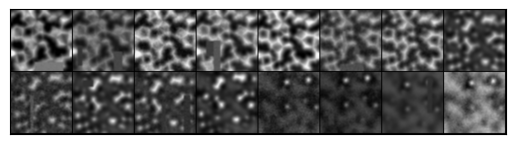

File: HDA7_35_8_66_1
AFM img & gt label:


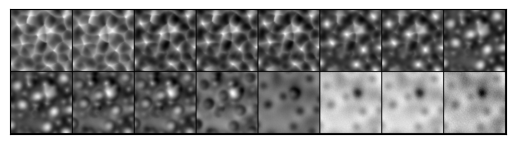

In [1]:
import os

import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import random

from datasets.dataset import AFMDataset
from demo import plot as vis

import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')

# show torch imgs
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

# Load afm dataset
device = (0, )
batch_size = 1

afm_train = AFMDataset(root_path = "/home/supercgor/gitfile/ARAI/datasets/data/bulkice", preload= True)
# afm_train = AFMDataset(root_path = "/gpfs/share/home/2000012508/ML2023/ARAI/datasets/data/bulkice", preload= True)
data_loader = torch.utils.data.DataLoader(afm_train, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)

for imgs, labels, filenames in data_loader:
    # imgs: B x 1 x 16 x 128 x 128
    # labels: B x 8 x 32 x 32 x 2 x 4
    break

img = imgs[0].permute(1,0,2,3)
print(f"File: {filenames[0]}")
print("AFM img & gt label:")
show(torchvision.utils.make_grid(img))
# show(vis.label2img(labels))

afm_exp = AFMDataset(root_path = "/home/supercgor/gitfile/ARAI/datasets/data/lots_exp/HDA", preload= True, label = False, file_list = "domain1.filelist", transform = None)

data_loader = torch.utils.data.DataLoader(afm_exp, batch_size = batch_size, shuffle = True, num_workers = 1, pin_memory = True)

for imgs, filenames in data_loader:
    # imgs: B x 1 x 16 x 128 x 128
    # labels: B x 8 x 32 x 32 x 2 x 4
    break

img = imgs[0].permute(1,0,2,3)
print(f"File: {filenames[0]}")
print("AFM img & gt label:")
show(torchvision.utils.make_grid(img))
# show(vis.label2img(labels))


# Check model

In [1]:
import torch
from model import UNetModel, NLayerDiscriminator
a = UNetModel(image_size = (16, 128, 128), 
              in_channels = 1, 
              model_channels = 32,
              out_channels = 1,
              num_res_blocks = 1,
              attention_resolutions = [], 
              dropout = 0,
              channel_mult = (1,2,2,4), 
              dims = 3, 
              time_embed= None,
              use_checkpoint=False).cuda()
#a.structure()

b = NLayerDiscriminator(1, (64, 128, 256))
b.structure()
# img = torch.randn((1, 1, 16, 128, 128), device = "cuda")

# fea = a(img)
# print(out.shape)
# print(torch.cuda.memory_summary())

----------------------------------------------------------------------------------------------------
|                     weight name                    |          weight shape          |   number   |
----------------------------------------------------------------------------------------------------
| blocks.0.0.weight                                  | 64, 1, 3, 3, 3                 | 1728       |
| blocks.0.0.bias                                    | 64,                            | 64         |
| blocks.0.1.weight                                  | 64,                            | 64         |
| blocks.0.1.bias                                    | 64,                            | 64         |
| blocks.1.0.weight                                  | 128, 64, 3, 3, 3               | 221184     |
| blocks.1.0.bias                                    | 128,                           | 128        |
| blocks.1.1.weight                                  | 128,                           | 128

In [13]:
import cv2
import os
import json
files = os.listdir("/home/supercgor/gitfile/data/bulkexp/combine_afm")
for i in files:
    dic = json.load(open(os.path.join("/home/supercgor/gitfile/data/bulkexp/combine_afm", i, "readme.json")))
    if dic['problem'] == "yes":
        print(i)
    
    

exp102
exp42
exp87
exp88
exp89
exp90
exp99


In [16]:
import torch
a = torch.tensor([[[1,2,3], [4,5,6.]]])
m = torch.nn.AdaptiveAvgPool2d(1)
m(a).flatten()

tensor([3.5000])

In [1]:
from model import NLayerDiscriminator
import torch

nld = NLayerDiscriminator(in_channels = 1, reduce="mean", channel_mult= (1,2,4,8))
pic = torch.randn(1, 1, 16, 128, 128)
nld(pic)

tensor([-0.0742], grad_fn=<MeanBackward1>)